In [ ]:
#We will be installing Conda and Rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import pandas as pd

In [ ]:
#load up previously generated data
df = pd.read_csv('Aromatase_bioactivity_data_preprocessed.csv')

In [ ]:
temp_df = pd.read_csv('temp_Aromatase_bioactivity_data_preprocessed.csv')

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 



In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
#Calculate descriptors
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(temp_df.canonical_smiles)

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,329.528,4.28820,2.0,2.0
1,315.501,3.89810,2.0,2.0
2,412.306,5.70542,0.0,3.0
3,319.383,4.63450,0.0,3.0
4,321.811,4.58780,0.0,3.0
...,...,...,...,...
2812,285.310,2.65916,0.0,5.0
2813,285.310,2.65916,0.0,5.0
2814,358.397,3.98320,0.0,5.0
2815,358.397,3.98320,0.0,5.0


In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.000,intermediate
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.000,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.000,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.000,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.000,active
...,...,...,...,...
2888,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,2.178,NaN
2889,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,10.000,NaN
2890,CHEMBL4634777,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,5550.000,NaN
2891,CHEMBL4639677,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,2850.000,NaN


In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.000,intermediate,329.528,4.28820,2.0,2.0
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.000,inactive,315.501,3.89810,2.0,2.0
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.000,active,412.306,5.70542,0.0,3.0
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.000,active,319.383,4.63450,0.0,3.0
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.000,active,321.811,4.58780,0.0,3.0
...,...,...,...,...,...,...,...,...
2888,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,2.178,NaN,NaN,NaN,NaN,NaN
2889,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,10.000,NaN,NaN,NaN,NaN,NaN
2890,CHEMBL4634777,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,5550.000,NaN,NaN,NaN,NaN,NaN
2891,CHEMBL4639677,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,2850.000,NaN,NaN,NaN,NaN,NaN


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
#Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative. Hence we have to deal with that
df_combined.standard_value.describe()

count    2.817000e+03
mean     2.230979e+10
std      7.328463e+11
min      0.000000e+00
25%      1.100000e+02
50%      1.100000e+03
75%      7.830000e+03
max      3.388442e+13
Name: standard_value, dtype: float64

In [ ]:
-np.log10( (10**-9)* 100000000 )

1.0

In [ ]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,intermediate,329.528,4.28820,2.0,2.0,7100.000
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,inactive,315.501,3.89810,2.0,2.0,50000.000
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,active,412.306,5.70542,0.0,3.0,238.000
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,active,319.383,4.63450,0.0,3.0,57.000
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,active,321.811,4.58780,0.0,3.0,54.000
...,...,...,...,...,...,...,...,...
2888,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,NaN,NaN,NaN,NaN,NaN,2.178
2889,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,NaN,NaN,NaN,NaN,NaN,10.000
2890,CHEMBL4634777,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,NaN,NaN,NaN,NaN,NaN,5550.000
2891,CHEMBL4639677,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,NaN,NaN,NaN,NaN,NaN,2850.000


In [ ]:
df_norm.standard_value_norm.describe()

count    2.817000e+03
mean     8.985847e+05
std      8.937262e+06
min      0.000000e+00
25%      1.100000e+02
50%      1.100000e+03
75%      7.830000e+03
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [ ]:
df_final = pIC50(df_norm)
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,intermediate,329.528,4.28820,2.0,2.0,5.148742
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,inactive,315.501,3.89810,2.0,2.0,4.301030
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,active,412.306,5.70542,0.0,3.0,6.623423
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,active,319.383,4.63450,0.0,3.0,7.244125
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,active,321.811,4.58780,0.0,3.0,7.267606
...,...,...,...,...,...,...,...,...
2888,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,NaN,NaN,NaN,NaN,NaN,8.661942
2889,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,NaN,NaN,NaN,NaN,NaN,8.000000
2890,CHEMBL4634777,CCC#CCOc1cc(Cn2ccnc2)c2oc3ccccc3c(=O)c2c1,NaN,NaN,NaN,NaN,NaN,5.255707
2891,CHEMBL4639677,CCC#CCOc1cc(Cn2ccnc2)c2c(=O)c3ccccc3oc2c1,NaN,NaN,NaN,NaN,NaN,5.545155


In [ ]:
df_final.pIC50.describe()

count    2817.000000
mean             inf
std              NaN
min         1.000000
25%         5.106238
50%         5.958607
75%         6.958607
max              inf
Name: pIC50, dtype: float64

In [ ]:
# I have removed intermediate compounds since I am only interested in the active and inactive ones
df_2class = df_final[df_final.bioactivity_class != 'intermediate' ]

df_2class.dropna(subset=['bioactivity_class'], inplace=True)
# df_2class = df_final[df_final.bioactivity_class != 'NaN']
df_2class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,inactive,315.501,3.89810,2.0,2.0,4.301030
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,active,412.306,5.70542,0.0,3.0,6.623423
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,active,319.383,4.63450,0.0,3.0,7.244125
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,active,321.811,4.58780,0.0,3.0,7.267606
6,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,active,319.383,4.63450,0.0,3.0,7.387216
...,...,...,...,...,...,...,...,...
2810,CHEMBL4446561,O=S(=O)(Nc1cccc(NS(=O)(=O)c2ccc(Cl)cc2)c1)c1cc...,active,396.410,4.19488,0.0,7.0,1.000000
2811,CHEMBL2299368,O=[N+]([O-])c1ccc(NC(=S)NCc2cccc(CNC(=S)Nc3ccc...,active,416.397,4.23140,0.0,8.0,6.096910
2812,CHEMBL1444,N#Cc1ccc(C(c2ccc(C#N)cc2)n2cncn2)cc1,active,285.310,2.65916,0.0,5.0,8.000000
2813,CHEMBL1093458,CC/C(=C(\c1ccc(O)cc1)c1ccc(OCCNC)cc1)c1ccccc1,active,285.310,2.65916,0.0,5.0,5.214670


---

In [ ]:
df_2class.to_csv('bioactivity_data_ForPart3.csv', index=False)

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [ ]:
#Import library
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

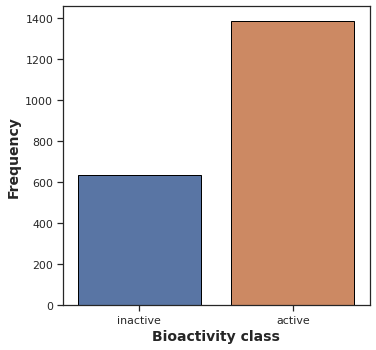

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**


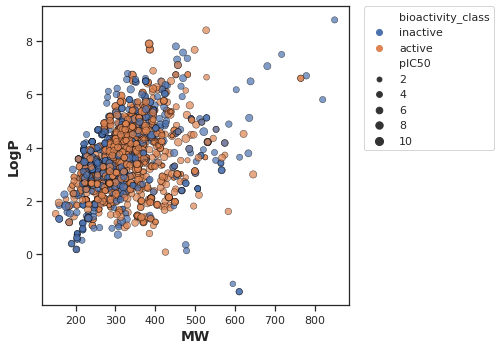

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

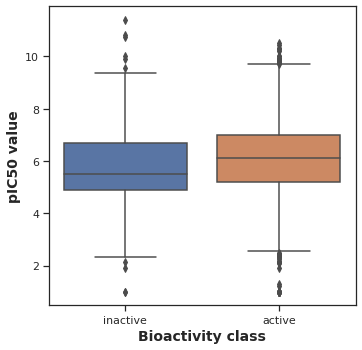

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,372515.5,2.296641e-08,0.05,Different distribution (reject H0)


#### **MW**

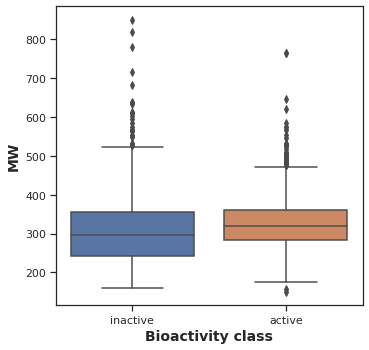

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,372516.0,2.298089e-08,0.05,Different distribution (reject H0)


#### **LogP**

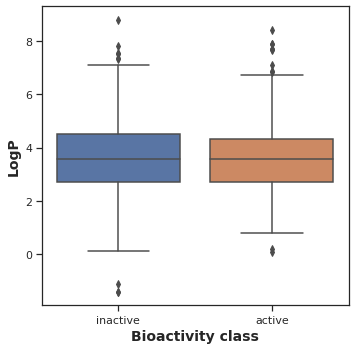

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,436065.5,0.405129,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

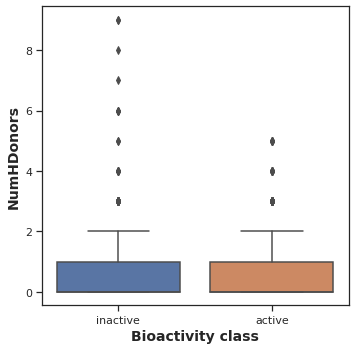

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,387233.5,4.746714e-07,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

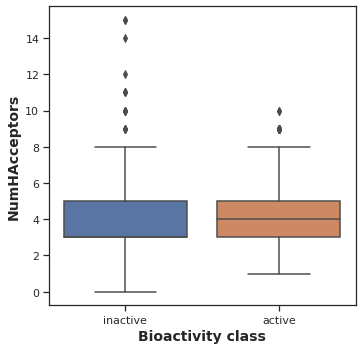

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,377786.0,1.459890e-07,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only MW exhibited ***statistically significant difference*** between the **actives** and **inactives** while the other 3 descriptors (LogP, NumHDonors and NumHAcceptors) shows ***no difference*** between **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_MW_vs_LogP.pdf (deflated 3%)
  adding: plot_MW.pdf (deflated 37%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: Aromatase_bioactivity_data_preprocessed.csv (deflated 82%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: bioactivity_data_ForPart3.csv (deflated 78%)
  adding: plot_bioactivity_class.pdf (deflated 37%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: temp_Aromatase_bioactivity_data_preprocessed.csv (deflated 82%)
